ベルヌーイ分布を用いたMNISTデータセットのモデリング

人工データを用いた多次元ガウス分布のモデリング

In [17]:
# 必要なライブラリのインポート

import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from keras.datasets import mnist
import seaborn as sns
import math
from scipy import stats

In [18]:
# ヘルパー関数の定義

def get_label_idxs(label: list, t_mnist: np.ndarray) -> np.ndarray:
  label_bool = np.any([t_mnist==label for label in labels], axis=0)
  label_idxs = np.where(label_bool)[0]

  return label_idxs

def transforms(data_all: np.ndarray, flatten=True, binarize=True) -> np.ndarray:
  data_all = data_all.astype(np.float64) / 255
  if flatten:
    data_all = data_all.reshape((data_all.shape[0], -1))
  if binarize:
    data_all = (data_all > 0.5).astype(np.uint8)

  return data_all

ベルヌーイ分布によるMNIST画像モデリング
MNIST画像の1種類のラベルのみを単純な(多次元)ベルヌーイ分布でモデリングする

In [19]:
NUM_SAMPLES = 600

(x_mnist, t_mnist), _ = mnist.load_data()
print(f'x_mnist: {x_mnist.shape}, t_mnist: {t_mnist.shape}')

labels = [3]

label_idxs = get_label_idxs(labels, t_mnist)

data_all = x_mnist[label_idxs][:NUM_SAMPLES]
print(f'data_all: {data_all.shape}')

x_mnist: (60000, 28, 28), t_mnist: (60000,)
data_all: (600, 28, 28)


<Axes: >

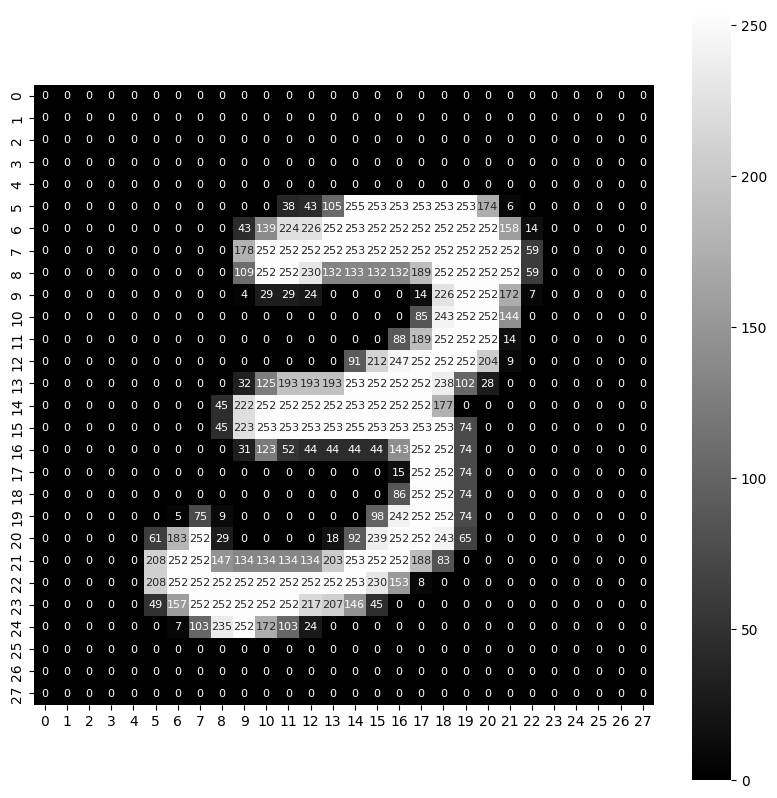

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(data_all[0], cmap='gray', annot=True, fmt='d', annot_kws={"fontsize":8}, square=True)

In [21]:
binary_data = transforms(data_all)
print(f'binary_data: {binary_data.shape}, set {np.unique(binary_data)}')

binary_data: (600, 784), set [0 1]


0の回数:  311
1の回数:  289


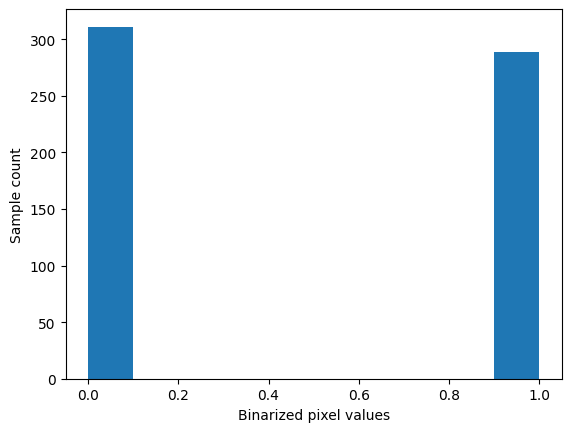

In [22]:
TARGET_PIXEL = 157

binary_pixel = binary_data[:, TARGET_PIXEL]

print('0の回数: ', len(binary_pixel) - sum(binary_pixel))
print('1の回数: ', sum(binary_pixel))

plt.hist(binary_pixel)
plt.xlabel('Binarized pixel values')
plt.ylabel('Sample count')
plt.show()

生成モデルの分布としてパラメータが$\mu$のベルヌーイ分布を考え，モデルを設計します．

$$
p_{\mu}({\bf x})=\prod_{i=1}^{N} \mu^{x_{i}}(1-\mu)^{1-x_{i}}
$$

$\mu$の推定量$\hat{\mu}$を最尤推定で求めます．

$$
\hat{\mu}=\underset{\mu}{\operatorname{argmax}} \sum_{i=1}^{N}\left[x_{i} \log \mu+\left(1-x_{i}\right) \log (1-\mu)\right]
$$

対数尤度関数を$\mu$について偏微分してゼロとおくことで，最尤推定量は次のように求まります．

$$
\hat{\mu}=\frac{1}{N}\sum_{i=1}^{N} x_{i}
$$

mu_hats: (784,)
0の回数:  302
1の回数:  298


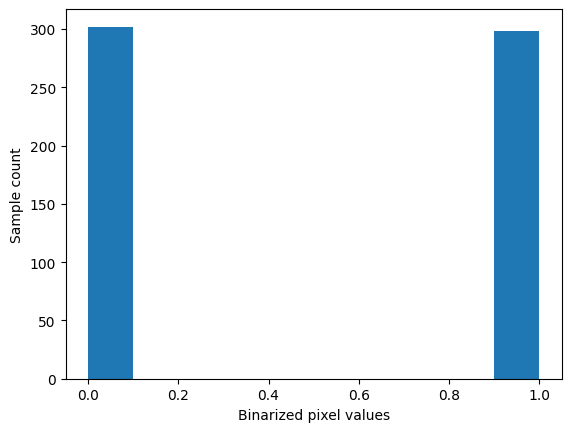

In [23]:
# 最尤推定
mu_hats = np.mean(binary_data, axis=0)
print(f'mu_hats: {mu_hats.shape}')

# TARGET_PIXELのmu_hatをパラメータとするベルヌーイ分布からデータを生成する
sampled_data = stats.bernoulli.rvs(p=mu_hats[TARGET_PIXEL], size=NUM_SAMPLES)
print('0の回数: ', len(sampled_data) - sum(sampled_data))
print('1の回数: ', sum(sampled_data))

plt.hist(sampled_data)
plt.xlabel('Binarized pixel values')
plt.ylabel('Sample count')
plt.show()

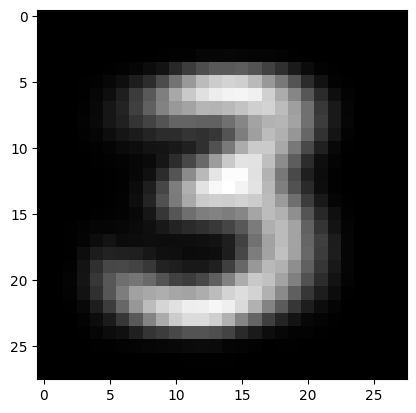

In [24]:
# ベルヌーイ分布のmu_hassを可視化
plt.imshow(mu_hats.reshape(28, 28), cmap='gray')

data_all: (1200, 28, 28)
binary_data: (1200, 784), set [0 1]
mu_hats: (784,)


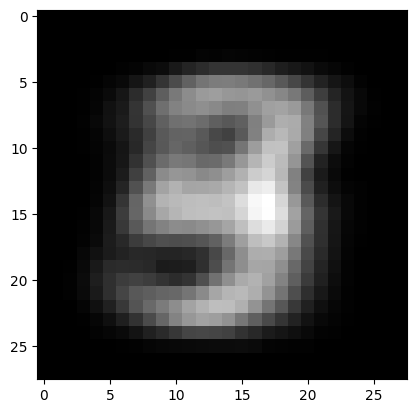

In [25]:
# 別のラベルを混ぜてモデリング
NUM_SAMPLES = 1200

labels = [3, 4]

label_idxs = get_label_idxs(labels, t_mnist)
data_all = x_mnist[label_idxs][:NUM_SAMPLES]
print(f'data_all: {data_all.shape}')

binary_data = transforms(data_all)
print(f'binary_data: {binary_data.shape}, set {np.unique(binary_data)}')

# 最尤推定
mu_hats = np.mean(binary_data, axis=0)
print(f'mu_hats: {mu_hats.shape}')

plt.imshow(mu_hats.reshape(28, 28), cmap='gray')

多次元ガウス分布による人工データモデリング

In [26]:
# 真の分布として単一のガウス分布を定義
_mu = np.array([0, 0])
_sigma = np.array([[1.0, 0.5], [0.5, 1.0]])

NUM_DATA = 3000

data_all = np.random.multivariate_normal(_mu, _sigma, NUM_DATA)

print(f'data_all: {data_all.shape}')

data_all: (3000, 2)


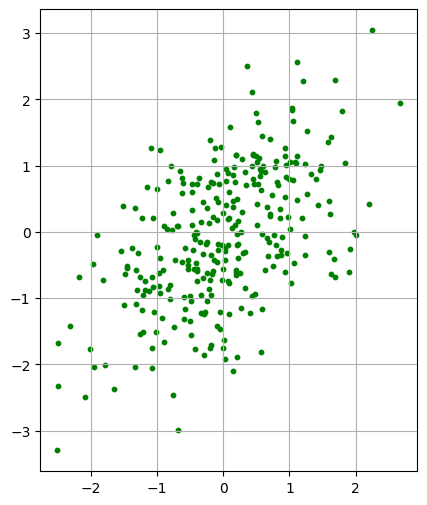

In [27]:
NUM_SAMPLES = 300

x = np.arange(-5, 5, 0.05)
y = np.arange(-5, 5, 0.05)

fig, ax = plt.subplots(figsize=(8.0, 6.0))
data_plot = plt.scatter(data_all.T[0, :NUM_SAMPLES], data_all.T[1, :NUM_SAMPLES], s=10, c='g')
ax.set_aspect('equal', 'box')
plt.grid(True)
plt.show()

生成モデルの分布として,パラメータが $\boldsymbol{\mu}$（平均ベクトル）と $\boldsymbol{\Sigma}$（共分散行列）の **多次元ガウス分布** を考え，モデルを設計します．

$$
p_{\boldsymbol{\mu}, \boldsymbol{\Sigma}}(\mathbf{x}) = \frac{1}{(2\pi)^{d/2} |\boldsymbol{\Sigma}|^{1/2}} \exp\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}) \right)
$$

$\boldsymbol{\mu}$ の推定量 $\hat{\boldsymbol{\mu}}$ と $\boldsymbol{\Sigma}$ の推定量 $\hat{\boldsymbol{\Sigma}}$ を 最尤推定で求めます．

対数尤度関数は次のようになります．

$$
\log p_{\boldsymbol{\mu}, \boldsymbol{\Sigma}}(\mathbf{X}) = -\frac{N d}{2} \log(2\pi) - \frac{N}{2} \log |\boldsymbol{\Sigma}| - \frac{1}{2} \sum_{i=1}^{N} (\mathbf{x}_i - \boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x}_i - \boldsymbol{\mu})
$$

この式を $\boldsymbol{\mu}$ と $\boldsymbol{\Sigma}$ について偏微分し，ゼロとおくことで最尤推定量が求まります．

- 平均ベクトルの最尤推定量:

$$
\hat{\boldsymbol{\mu}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{x}_i
$$

- 共分散行列の最尤推定量:

$$
\hat{\boldsymbol{\Sigma}} = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{x}_i - \hat{\boldsymbol{\mu}})(\mathbf{x}_i - \hat{\boldsymbol{\mu}})^T
$$

この結果より，最尤推定では データの平均と共分散 を計算することで，ガウス分布のパラメータを推定できることが分かります．

In [28]:
# データの平均と共分散を求める関数
def estimate_gaussian_params(data_all):
  mu = np.mean(data_all, axis=0)
  sigma = np.cov(data_all, rowvar=False)
  return mu, sigma

mu_hats, sigma_hats = estimate_gaussian_params(data_all)

推定したパラメータに基づくガウス分布を可視化

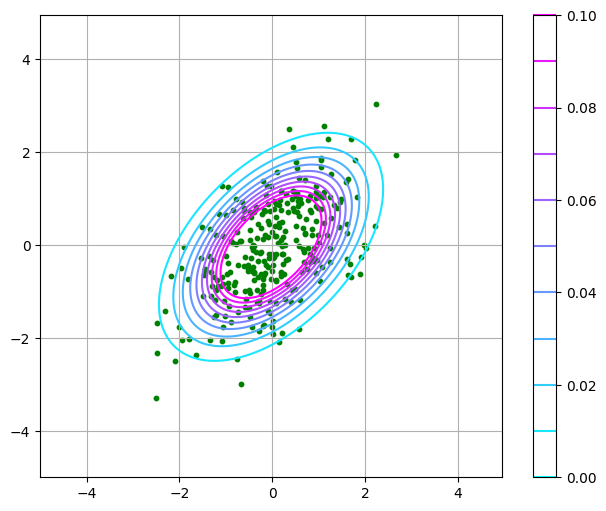

In [30]:
# 共分散行列の逆行列式
sigma_hats_inv = np.linalg.inv(sigma_hats)
sigma_hats_det = np.linalg.det(sigma_hats)

# メッシュグリッドの作成
x = np.arange(-5, 5, 0.05)
y = np.arange(-5, 5, 0.05)
X, Y = np.meshgrid(x, y)

# ガウス密度関数
def gaussian_density(x, mu, sigma_inv, sigma_det):
  diff = x - mu
  exponent = -0.5 * diff.T @ sigma_inv @ diff
  return np.exp(exponent) / (2 * np.pi * np.sqrt(sigma_det))

# 密度の計算
Z = np.zeros_like(X)
for i in range(X.shape[0]):
  for j in range(Y.shape[1]):
    Z[i, j] = gaussian_density(np.array([X[i, j], Y[i, j]]), mu_hats, sigma_hats_inv, sigma_hats_det)

# データ点の可視化
fig, ax = plt.subplots(figsize=(8.0, 6.0))
data_plot = plt.scatter(data_all[:NUM_SAMPLES, 0], data_all[:NUM_SAMPLES, 1], s=10, c='g')
contour = ax.contour(X, Y, Z, levels=[0.01 * i for i in range(11)], cmap='cool')
plt.colorbar(contour)
ax.set_aspect('equal', 'box')
plt.grid(True)
plt.show()

In [41]:
# 新しいデータの生成
NUM_GENERATED = 100
new_data = np.random.multivariate_normal(mu_hats, sigma_hats, NUM_GENERATED)
print(f'new_data: {new_data.shape}')

new_data: (100, 2)


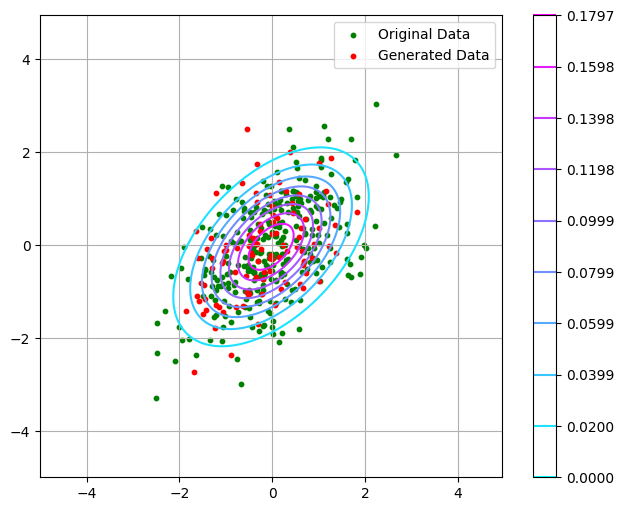

In [42]:
fig, ax = plt.subplots(figsize=(8.0, 6.0))
data_plot = plt.scatter(data_all[:NUM_SAMPLES, 0], data_all[:NUM_SAMPLES, 1], s=10, c='g', label='Original Data')
generated_plot = plt.scatter(new_data[:, 0], new_data[:, 1], s=10, c='r', label='Generated Data')
contour = ax.contour(X, Y, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap='cool')
plt.colorbar(contour)
ax.set_aspect('equal', 'box')
plt.legend()
plt.grid(True)
plt.show()